In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

D:\anaconda\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Wall time: 4min 55s


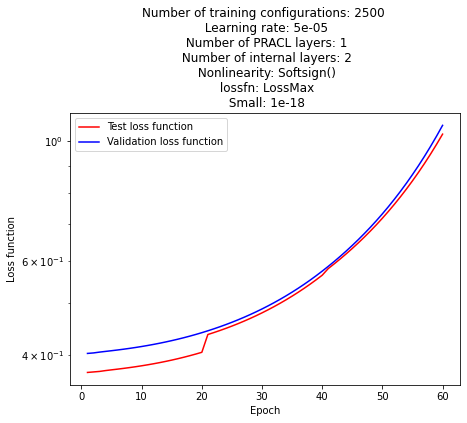

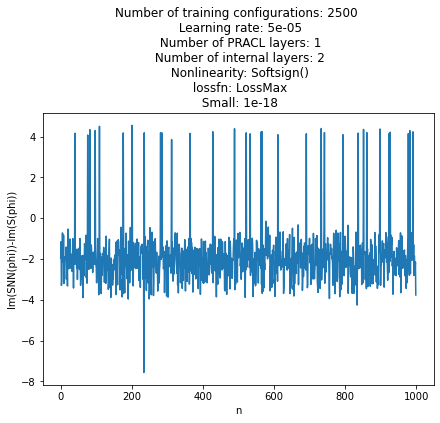

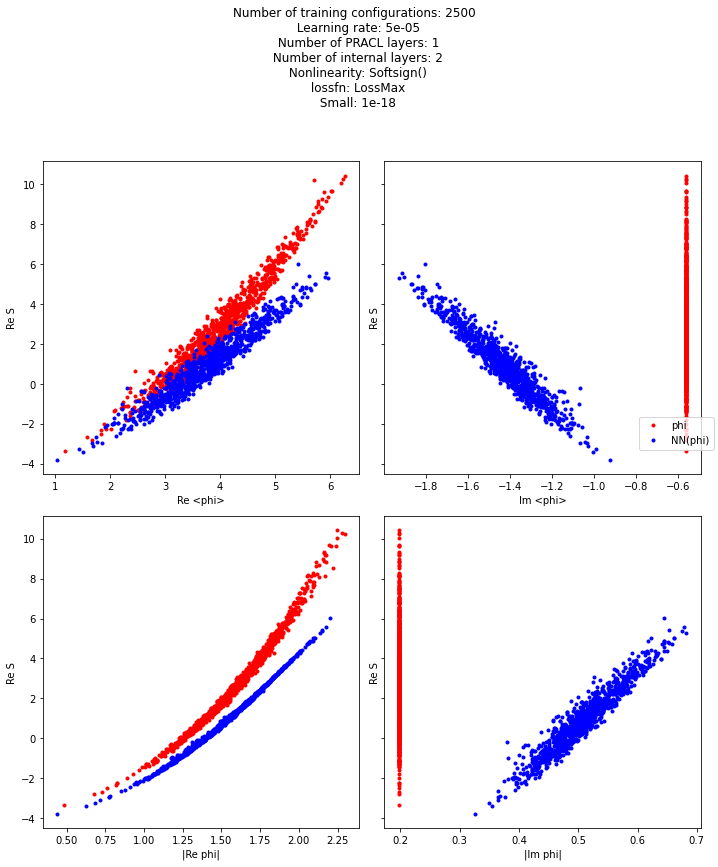

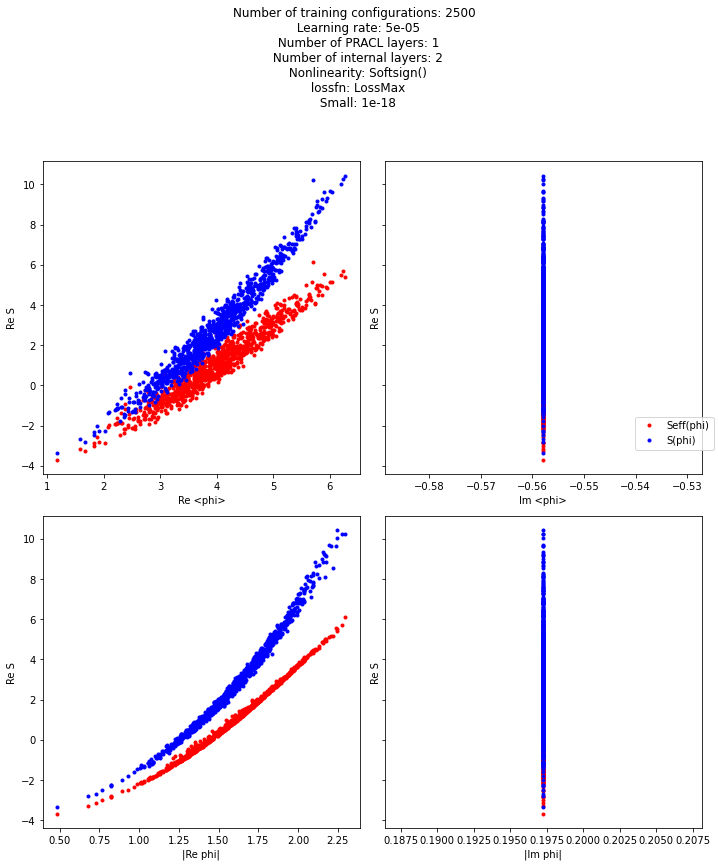

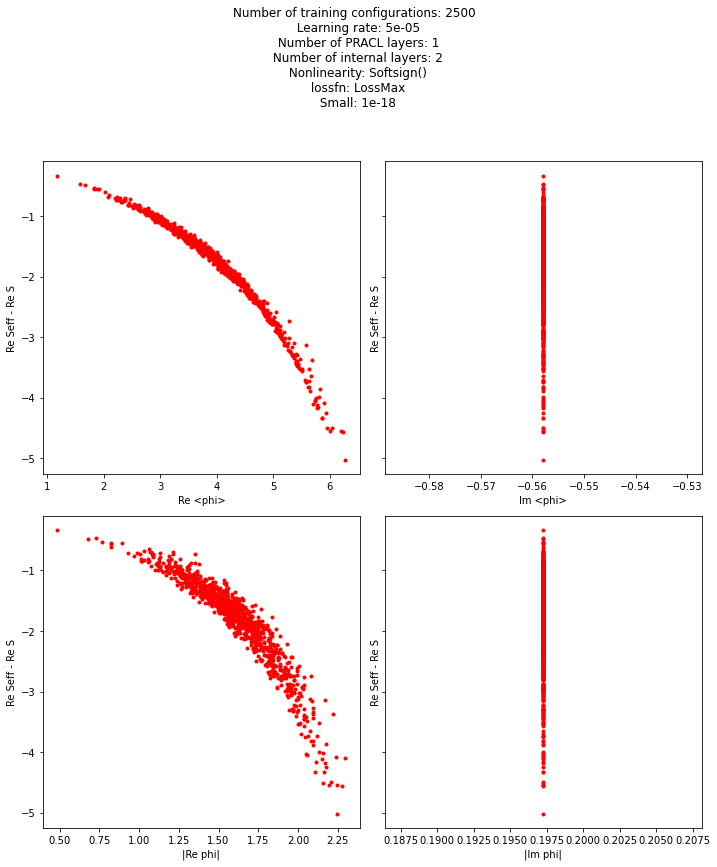

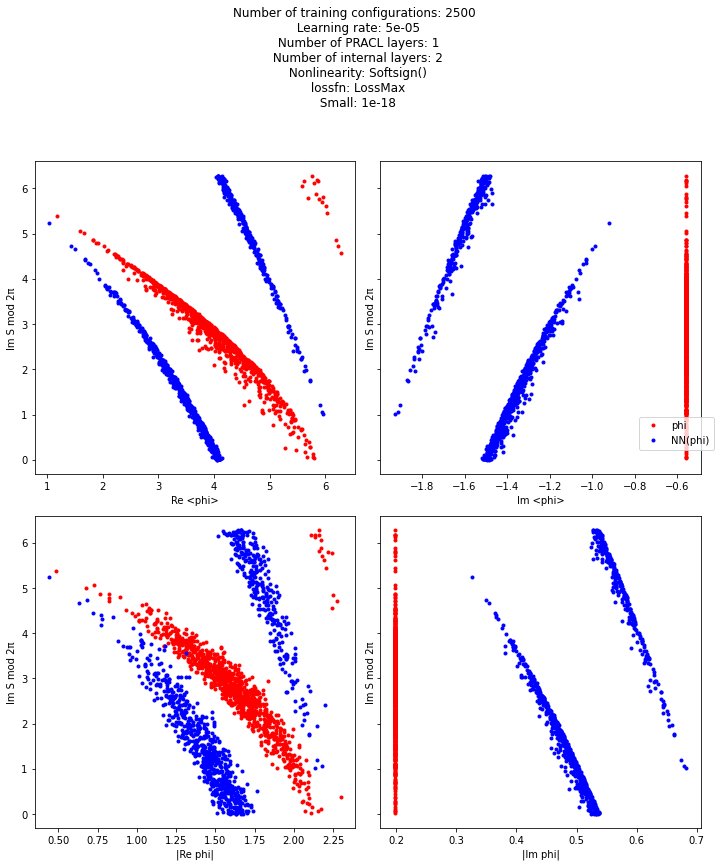

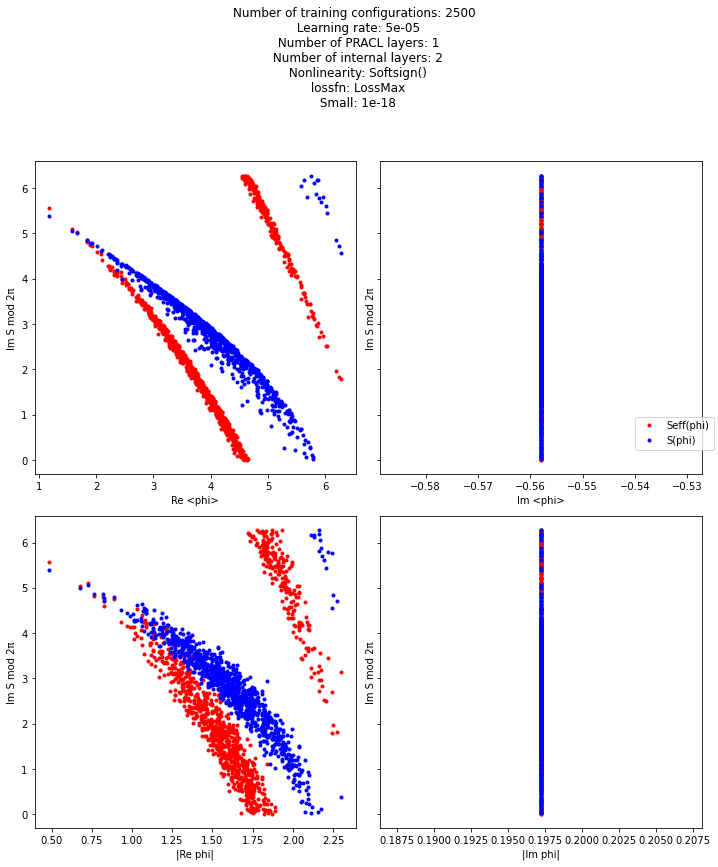

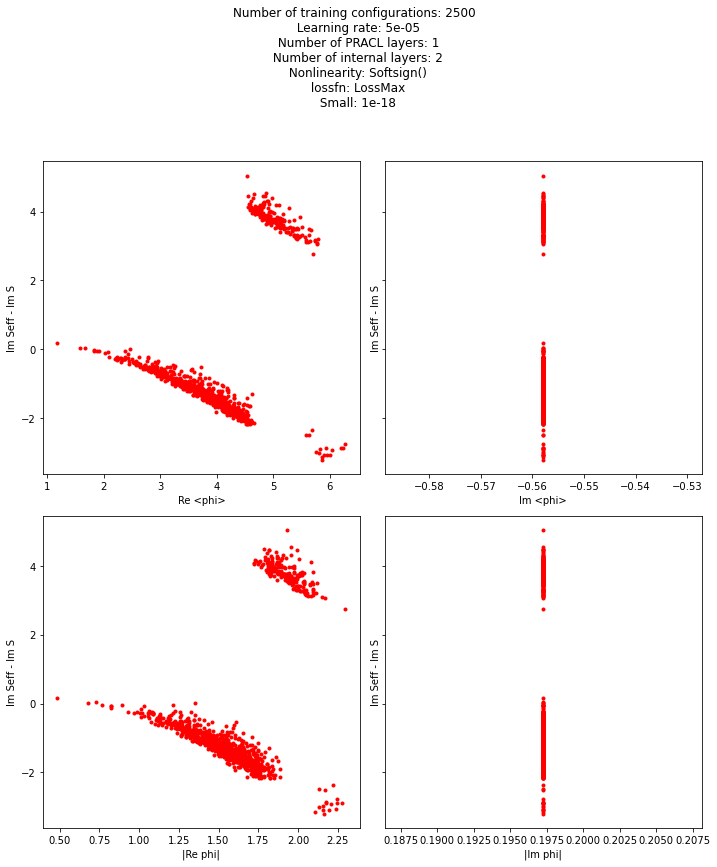

In [2]:
%%time
# plotting is done using matplotlib 
import torch
import matplotlib.pyplot as plt

# matplotlib works better with numpy.
import numpy as np

# For fitting wie simply use
from scipy.optimize import curve_fit

# Easier looping
import itertools as it


# The Layers are implemented using torch.nn.Module:
# Implementation the Paired (Random) Coupling Layer (PRCL)
from layer import PRCL
# Implementation of the Affine Coupling
from layer import AffineCoupling

# The Layers are set up to calculate the log det on the fly. 
# This requires a special implementation of the sequential container
from layer import Sequential



# the code is absolutely not optimized for GPU nor could the 
# 2 site problem fill a GPU thus it might be best to keep it 
# with device = 'cpu'.
torchTensorArgs = {
    "device": torch.device('cpu'),
    "dtype" : torch.cdouble
}



### Number of time slices
Nt   = 4

# Controle the continuum limit with
beta = 1

# On site interaction
U    = 1

# chemical potential
mu   = 1

# lattice spacing
delta= beta/Nt

# Put to 0 if not desired:
# tangent plane 
tpOffset = -6.97420945e-02 # Nt=4,beta=U=mu=1
#tpOffset = 0

# number of ions in the lattice
Nx = 2

# Make all variables unit less
U  = delta * U
mu = delta * mu

# hopping matrix (particles)
# exp( \kappa + C^p )
expKappa_p = torch.zeros((Nx, Nx),**torchTensorArgs)
expKappa_p[0, 0] = np.cosh(delta) * np.exp(mu)
expKappa_p[0, 1] = np.sinh(delta) * np.exp(mu)
expKappa_p[1, 0] = np.sinh(delta) * np.exp(mu)
expKappa_p[1, 1] = np.cosh(delta) * np.exp(mu)

# hopping matrix (holes)
# exp( \kappa + C^h )
expKappa_h = torch.zeros((Nx, Nx),**torchTensorArgs)
expKappa_h[0, 0] =  np.cosh(delta) * np.exp(-mu)
expKappa_h[0, 1] = -np.sinh(delta) * np.exp(-mu)
expKappa_h[1, 0] = -np.sinh(delta) * np.exp(-mu)
expKappa_h[1, 1] =  np.cosh(delta) * np.exp(-mu)


def M(phi,species):
   
    Nt,Nx = phi.shape
    
    M = torch.zeros((Nt, Nx, Nt, Nx), **torchTensorArgs)
    
    if species == 1:
        expKappa = expKappa_p
    elif species == -1:
        expKappa = expKappa_h
    else:
        return ValueError(f"Fermion Matrix got wrong species argument. Must be +/- 1 but is {species}.")
    
    
    expphi = torch.exp(species*1.j*phi)
    
    ts = torch.arange(0,Nt-1)
    M[ts,:,ts,:] = torch.eye(Nx,**torchTensorArgs)
    
    M[ts+1, :, ts, :] = -expKappa[:, :] * expphi[ts,None, :]

    M[Nt - 1, :, Nt - 1, :] = torch.eye(Nx,**torchTensorArgs)
  
    M[0, :, Nt-1, :] = expKappa[:, :] * expphi[Nt-1,None, :]

    return M



def logdetM(phi,species):    
    
    return torch.log(torch.linalg.det(M(phi,species).reshape(Nt*Nx,Nt*Nx)))



# the action of the system
def action(phi):
   
    return (phi*phi).sum()/(2*U) - logdetM(phi,+1) - logdetM(phi,-1) 


small = 0.000000000000000001
verySmallTensor1 = torch.normal(0,small,size=(Nt, Nx//2), **torchTensorArgs)
verySmallTensor2 = torch.normal(0,small,size=(Nt, Nx//2, Nt, Nx//2), **torchTensorArgs)


class LinearTransformation(torch.nn.Module):
    def __init__(self, Nt, Nx):
        super(LinearTransformation, self).__init__()
        self.register_parameter(name='bias', param=torch.nn.Parameter(verySmallTensor1))
        self.register_parameter(name='weight', param=torch.nn.Parameter(verySmallTensor2))

    def forward(self, x):
        return torch.tensordot(x,self.weight,dims=([-1,-2],[0,1])) + self.bias
        



def LossMax(phi, logDet):
    n,Nt,Nx = phi.shape
    S = torch.zeros(n,**torchTensorArgs)
    for i in range(n):
        S[i] = action(phi[i,:,:])
    S -= logDet
    return torch.exp(-S).abs().mean()


def LossMin(phi, logDet):
    n,Nt,Nx = phi.shape
    S = torch.zeros(n,**torchTensorArgs)
    for i in range(n):
        S[i] = action(phi[i,:,:])
        
    return (S.imag - logDet.imag).abs().mean()



class complexRelu(torch.nn.Module):
    def __init__(self):
        super(complexRelu, self).__init__()
    def forward(self,z):
        return 0.5*(1+torch.cos(torch.angle(z)))*z


lossfunctions = [LossMax, LossMin]
NLF = len(lossfunctions)



activationFunctions = [torch.nn.Softsign(), torch.nn.Tanh(),complexRelu()]
NAF = len(activationFunctions)

def averagePhi(phi):
    return phi.sum(dim=(-1,-2))
def modPhi(phi):
    return torch.sqrt((torch.square(phi)).sum(dim=(-1,-2)))

#%%time

import torch.optim as optim

EPOCHS = 60
epochs = np.arange(1,EPOCHS+1)

# GRID SEARCH

learningRates = np.linspace(0.00005,0.002,25)

maxNoConf = 10000 # maximum number of training data that we will ever use
epoch_of_resample = 20 # number of epochs after which we change the training data
trainingSets = EPOCHS//epoch_of_resample # number of training sets needed 

training_data = torch.rand((trainingSets,maxNoConf,Nt,Nx),**torchTensorArgs).real+1.j*tpOffset 

learnConfigurationNumbers = np.arange(2500,maxNoConf,500)

NLR = len(learningRates)
NLCN = len(learnConfigurationNumbers)

Nconf_valid = 1000
phivalid = torch.rand((Nconf_valid,Nt,Nx),**torchTensorArgs).real+1.j*tpOffset 
nvec = np.arange(0,Nconf_valid,1)
x = torch.zeros((NAF,Nconf_valid),**torchTensorArgs)
y = torch.zeros(Nconf_valid,**torchTensorArgs)
z = torch.zeros(Nconf_valid,**torchTensorArgs)


PRACL = [1,2,4]       # numbers of PRACL layers that we will test
internal = [2,4,8,16]  # number of internal layers that we will test

#For the purposes of these plots, we only use 2 internal layers
internalLayer=2       

NPR = len(PRACL)
NINT = len(internal)

LOSSES = torch.zeros(NLF,NAF,NLCN, NLR, NPR,EPOCHS)
LossValid = torch.zeros(NLF,NAF,NLCN, NLR,NPR,EPOCHS)
BigLoss = torch.zeros(NLF,NAF,NLCN, NLR, NPR)

phiii = torch.zeros((NAF,Nconf_valid,Nt,Nx),**torchTensorArgs)

for p in range(1): 
#for p in range(NLF):   # loss function
    
    Loss = lossfunctions[p]
    if Loss == LossMax:
        value = True
        handle='LossMax'
    else:
        value = False
        handle='LossMin'

    for n in range(1):    
    #for n in range(NAF):   # nonlinear activation function

        nonlinearity = activationFunctions[n]
        def generate_parameters(internalLayer):

            layer = []
            for _ in range(internalLayer-1):

                d = LinearTransformation(Nt, Nx)
                layer.append(d)
                layer.append(nonlinearity)

            e = LinearTransformation(Nt, Nx)

            layer.append(e)

            return torch.nn.Sequential(*layer)

        def generate_coupling(internalLayer):    
            return AffineCoupling( m = generate_parameters(internalLayer), a = generate_parameters(internalLayer) )

        # ... training loop ...

        for i in range(1):
        #for i in range(NLCN):        # number of training configurations 

            Nconf_learn = learnConfigurationNumbers[i]
            
            for j in range(1):
            #for j in range(NLR):   # learning rate 

                LR = learningRates[j]
                #for k in range(1):
                for k in range(1):   # number of PRACL layers

                    numPRACLLayers = PRACL[k]

                    #for m in range(NINT):   # number of internal layers

                        #internalLayer = internal[m]

                    NN = []     # initialise the NN

                    for _ in range(numPRACLLayers):
                        NN.append(
                            PRCL(
                                Nt,
                                Nx,
                                coupling1 = generate_coupling(internalLayer),
                                coupling2 = generate_coupling(internalLayer),
                            )
                        )

                    NN = Sequential(NN)

                    optimizer = optim.Adam(NN.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False, maximize=value)
               
                    # initialise the first set of training data
                    phiR = training_data[0,:Nconf_learn,...]
            
                    for epoch in range(EPOCHS):

                        phiM, logDetJ_NN = NN(phiR)
                        loss = Loss(phiM, logDetJ_NN)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        LOSSES[p][n][i][j][k][epoch] = loss
                        
                        
                        # save the NN 

                        #if ((epoch+1) % 10 == 0):
                            #PATH = f"NN, Nconf = {Nconf_learn}, learning rate = {LR}, numPRACLLayers = {numPRACLLayers},internalLayer={internalLayer},nonlinearity={nonlinearity},lossfn={handle},{epoch} epochs.pdf"
                            #torch.save(NN.state_dict(), PATH)
                        
                        # change the training set
                        
                        if (((epoch+1) % epoch_of_resample == 0) and epoch+1 != EPOCHS):
                            phiR = training_data[(epoch+1) // epoch_of_resample,:Nconf_learn,...]

                        # validation
                        with torch.no_grad():
                            PHIvalid, logD = NN(phivalid)
                            LossValid[p][n][i][j][k][epoch] = Loss(PHIvalid, logD)
                            
                        if loss.item() >= 1e10:
                            
                            LOSSES[p][n][i][j][k][(epoch+1):]=loss
                            break

                    BigLoss[p][n][i][j][k] = loss.item()
                    phiii[n]=PHIvalid
                    
                    
                    # PLOTTING
                    
                    # loss fn plot
                    
                    fig = plt.figure(figsize=(7,5))
                    plt.plot(epochs, LOSSES[p][n][i][j][k].detach().numpy(),  '-r', label='Test loss function')
                    plt.yscale('log')
                    plt.xlabel('Epoch')
                    plt.ylabel('Loss function')

                    plt.plot(epochs, LossValid[p][n][i][j][k].detach().numpy(), '-b', label='Validation loss function')
                    plt.legend()

                    plt.title(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}")
                    plt.savefig(f"Loss fn plot, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    # safety checks
                    
                    for h in range(Nconf_valid):
                    
                        y[h] = action(PHIvalid[h])   # S(NN(phi))
                        z[h] = action(phivalid[h])   # S(phi)
                        x[n][h] = y[h] - z[h]
                        
                    
                    
                    '''
                    # real part of S should increase - or not
                    
                    fig = plt.figure(figsize=(7,5))
                    plt.plot(x[n].real.detach().numpy())
                    #plt.plot(nvec,y.real.detach().numpy(), '-b', label = 'NN(phi)')
                    #plt.plot(nvec,z.real.detach().numpy(), '-r', label = 'phi')
                    #plt.yscale('log')
                    plt.xlabel('n')
                    plt.ylabel('Re(S(phi))')
                    plt.legend()
                    plt.title(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}")
                    plt.savefig(f"Re S increase, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    plt.show()
                    '''
                    # imag part of action should be const
                    
                    fig = plt.figure(figsize=(7,5))
                    plt.plot(nvec,x[n].imag.detach().numpy())
                    plt.xlabel('n')
                    plt.ylabel('Im(SNN(phi))-Im(S(phi))')
                    plt.title(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}")
                    plt.savefig(f"Im S const, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    
                    
                    # Action statistics
                    
                    # y = Re s
                    
                    y1phi = z.real.detach().numpy()
                    y1NNphi = y.real.detach().numpy()
                    
                    x1phi = (averagePhi(phivalid)).real.detach().numpy()
                    x1NNphi = (averagePhi(PHIvalid)).real.detach().numpy()
                    
                    x2phi = (averagePhi(phivalid)).imag.detach().numpy()
                    x2NNphi = (averagePhi(PHIvalid)).imag.detach().numpy()
                    
                    x3phi = (modPhi(phivalid.real)).detach().numpy()
                    x3NNphi = (modPhi(PHIvalid.real)).detach().numpy()
                    
                    x4phi = (modPhi(phivalid.imag)).detach().numpy()
                    x4NNphi = (modPhi(PHIvalid.imag)).detach().numpy()
                    

                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y1phi, '.r', label = 'phi')
                    axs[0,0].plot(x1NNphi, y1NNphi, '.b', label = 'NN(phi)')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y1phi, '.r')
                    axs[0,1].plot(x2NNphi, y1NNphi, '.b')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y1phi, '.r')
                    axs[1,0].plot(x3NNphi, y1NNphi, '.b')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y1phi, '.r')
                    axs[1,1].plot(x4NNphi, y1NNphi, '.b')
                    axs[1,1].set_xlabel('|Im phi|')
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Re S')
                        
                   
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.legend(loc="right", ncol=1)
                    fig.savefig(f"Re S, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)

                    
                    
                    # Seff
                    
                    y3phi = y1NNphi - logD.real.detach().numpy()                    
                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y3phi, '.r', label = 'Seff(phi)')
                    axs[0,0].plot(x1phi, y1phi, '.b', label = 'S(phi)')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y3phi, '.r')
                    axs[0,1].plot(x2phi,y1phi, '.b')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y3phi, '.r')
                    axs[1,0].plot(x3phi, y1phi, '.b')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y3phi, '.r')
                    axs[1,1].plot(x4phi, y1phi, '.b')
                    axs[1,1].set_xlabel('|Im phi|')
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Re S')
                        
                   
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.legend(loc="right", ncol=1)
                    fig.savefig(f"Re Seff vs Re S, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    # Seff - S
                    
                    y5phi = y3phi - y1phi                    
                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y5phi, '.r')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y5phi, '.r')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y5phi, '.r')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y5phi, '.r')
                    axs[1,1].set_xlabel('|Im phi|')
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Re Seff - Re S')
                        
                   
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.savefig(f"Re Seff - Re S, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    
                    y2phi = z.imag.detach().numpy()%(2*np.pi)
                    y2NNphi = y.imag.detach().numpy()%(2*np.pi)
                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y2phi, '.r', label = 'phi')
                    axs[0,0].plot(x1NNphi, y2NNphi, '.b', label = 'NN(phi)')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y2phi, '.r')
                    axs[0,1].plot(x2NNphi, y2NNphi, '.b')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y2phi, '.r')
                    axs[1,0].plot(x3NNphi, y2NNphi, '.b')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y2phi, '.r')
                    axs[1,1].plot(x4NNphi, y2NNphi, '.b')
                    axs[1,1].set_xlabel('|Im phi|')
         
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Im S mod 2π')
                        
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.legend(loc="right", ncol=1)
                    fig.savefig(f"Im S mod 2π, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    # Seff
                    
                    y4phi = (y.imag.detach().numpy()- logD.imag.detach().numpy())%(2*np.pi)
                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y4phi, '.r', label = 'Seff(phi)')
                    axs[0,0].plot(x1phi, y2phi, '.b', label = 'S(phi)')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y4phi, '.r')
                    axs[0,1].plot(x2phi,y2phi, '.b')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y4phi, '.r')
                    axs[1,0].plot(x3phi, y2phi, '.b')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y4phi, '.r')
                    axs[1,1].plot(x4phi, y2phi, '.b')
                    axs[1,1].set_xlabel('|Im phi|')
         
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Im S mod 2π')
                        
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.legend(loc="right", ncol=1)
                    fig.savefig(f"(Im Seff vs Im S) mod 2π, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    
                    
                    # Seff - S
                    
                    y6phi = y4phi - y2phi                    
                    
                    fig, axs = plt.subplots(2, 2, sharey=True,figsize=(10,10))
                    
                    axs[0,0].plot(x1phi, y6phi, '.r')
                    axs[0,0].set_xlabel('Re <phi>')
                    
                    axs[0,1].plot(x2phi,y6phi, '.r')
                    axs[0,1].set_xlabel('Im <phi>')
                    
                    axs[1,0].plot(x3phi, y6phi, '.r')
                    axs[1,0].set_xlabel('|Re phi|')
                    
                    axs[1,1].plot(x4phi, y6phi, '.r')
                    axs[1,1].set_xlabel('|Im phi|')
                    
                    for ax in axs.flat:
                        ax.set(ylabel='Im Seff - Im S')
                        
                   
                    fig.suptitle(f"Number of training configurations: {Nconf_learn} \n Learning rate: {LR}\n Number of PRACL layers: {numPRACLLayers}\n Number of internal layers: {internalLayer}\n Nonlinearity: {nonlinearity}\n lossfn: {handle}\n Small: {small}",y=1.2)
                    
                    fig.tight_layout() 
                    fig.savefig(f"Im Seff - Im S, Nconf_{Nconf_learn},lr_{LR}, NPRACL_{numPRACLLayers},Ninternal_{internalLayer}, Nonlinearity_{nonlinearity}, lossfn_{handle}.pdf",bbox_inches='tight', dpi=150)
                    


In [6]:
over =0 
for i in x[0]:
    if (i.imag.detach().numpy() < -1):
        over = over+1
over


906

In [11]:
phivalid

tensor([[[0.9529-0.0697j, 0.0303-0.0697j],
         [0.4001-0.0697j, 0.4539-0.0697j],
         [0.5450-0.0697j, 0.2378-0.0697j],
         [0.3847-0.0697j, 0.8668-0.0697j]],

        [[0.8807-0.0697j, 0.3842-0.0697j],
         [0.1476-0.0697j, 0.2604-0.0697j],
         [0.8190-0.0697j, 0.0041-0.0697j],
         [0.9208-0.0697j, 0.1267-0.0697j]],

        [[0.8912-0.0697j, 0.9283-0.0697j],
         [0.8346-0.0697j, 0.8151-0.0697j],
         [0.5373-0.0697j, 0.2928-0.0697j],
         [0.5350-0.0697j, 0.2172-0.0697j]],

        ...,

        [[0.8652-0.0697j, 0.4928-0.0697j],
         [0.2050-0.0697j, 0.0156-0.0697j],
         [0.8009-0.0697j, 0.6614-0.0697j],
         [0.5196-0.0697j, 0.7655-0.0697j]],

        [[0.5856-0.0697j, 0.1044-0.0697j],
         [0.4161-0.0697j, 0.7073-0.0697j],
         [0.4689-0.0697j, 0.9319-0.0697j],
         [0.2097-0.0697j, 0.6101-0.0697j]],

        [[0.9436-0.0697j, 0.9937-0.0697j],
         [0.4751-0.0697j, 0.3008-0.0697j],
         [0.8373-0.0697j, 0.78

### Generate a random configuration to see where the NN takes it

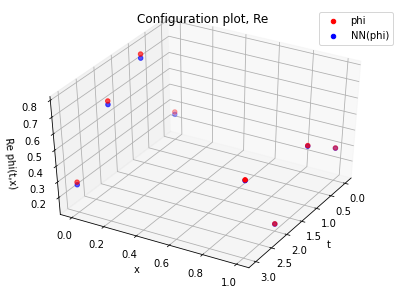

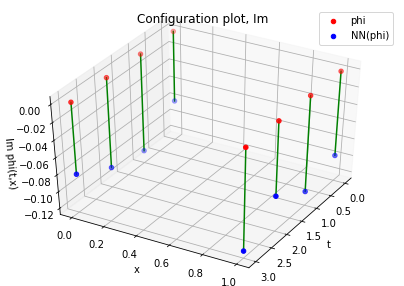

In [12]:
config = torch.rand((1,Nt,Nx),**torchTensorArgs).real + 0j
NNconfig, logdet = NN(config)

x = np.arange(0,Nx,1)
t = np.arange(0,Nt,1)
z1 = config[0]
z2 = NNconfig[0]


X, T = np.meshgrid(x,t)

fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')
ax.scatter3D(T, X, z1.real.detach().numpy(),  color='red', label = 'phi',cmap='binary',)
ax.scatter3D(T, X, z2.real.detach().numpy(), color='blue', label='NN(phi)',cmap='binary')
ax.legend()

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('Re phi(t,x)');
ax.view_init(40, 30)

plt.title('Configuration plot, Re')
plt.show()

fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')
ax.scatter3D(T, X, z1.imag.detach().numpy(),  color='red', label = 'phi',cmap='binary',)
ax.scatter3D(T, X, z2.imag.detach().numpy(), color='blue', label='NN(phi)',cmap='binary')
ax.legend()

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('Im phi(t,x)');
ax.view_init(40, 30)

for t0 in t:
    for x0 in x:
        ax.plot([t0,t0],[x0,x0],[z1.imag.detach().numpy()[t0,x0],z2.imag.detach().numpy()[t0,x0]], 'g')
        
plt.title('Configuration plot, Im')

plt.show()

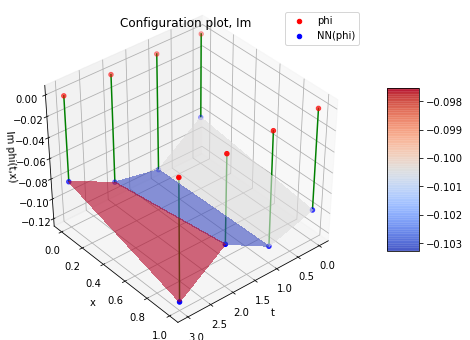

In [17]:
from matplotlib import cm
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')

for t0 in t:
    for x0 in x:
        ax.plot([t0,t0],[x0,x0],[z1.imag.detach().numpy()[t0,x0],z2.imag.detach().numpy()[t0,x0]], 'g')
        

ax.scatter3D(T, X, z1.imag.detach().numpy(),  color='red', label = 'phi',cmap='binary',)
ax.scatter3D(T, X, z2.imag.detach().numpy(), color='blue', label='NN(phi)',cmap='binary')
ax.legend(loc='best')


# Plot the surface.
surf = ax.plot_surface(T, X, z2.imag.detach().numpy(), cmap=cm.coolwarm,
                       linewidth=0, alpha=0.6,antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)


ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('Im phi(t,x)');
ax.view_init(40, 50)


plt.title('Configuration plot, Im')

plt.show()

In [18]:
logD

tensor([-0.1160-0.5847j, -0.1176-0.5433j, -0.1217-0.6850j, -0.1170-0.6671j,
        -0.1138-0.5736j, -0.1065-0.4446j, -0.1162-0.5841j, -0.1128-0.5991j,
        -0.1070-0.4606j, -0.1167-0.6757j, -0.1185-0.6499j, -0.1178-0.5968j,
        -0.1144-0.5750j, -0.1098-0.5751j, -0.1110-0.5957j, -0.1082-0.5291j,
        -0.1195-0.6622j, -0.1155-0.6219j, -0.1195-0.6098j, -0.1228-0.6913j,
        -0.1030-0.4114j, -0.1074-0.5312j, -0.1074-0.5976j, -0.1165-0.6305j,
        -0.1128-0.5734j, -0.1036-0.5000j, -0.1144-0.5103j, -0.1142-0.6201j,
        -0.1193-0.5954j, -0.1155-0.5687j, -0.1163-0.6097j, -0.1132-0.5744j,
        -0.1157-0.6281j, -0.1097-0.5589j, -0.1086-0.4808j, -0.1180-0.5600j,
        -0.1187-0.6913j, -0.1027-0.4969j, -0.1176-0.5457j, -0.1142-0.6029j,
        -0.1109-0.5916j, -0.1108-0.6046j, -0.1147-0.5589j, -0.1170-0.6044j,
        -0.1149-0.5695j, -0.1104-0.6392j, -0.1112-0.5428j, -0.1144-0.6795j,
        -0.1213-0.6329j, -0.1142-0.5614j, -0.1202-0.5948j, -0.1050-0.5509j,
        -0.1

In [24]:
for p in NN.parameters():
    print(p)

Parameter containing:
tensor([[0.00228905048187513869-0.01909923936580076517j],
        [0.00203155031498296204-0.01919111258779353929j],
        [0.00204251681994634376-0.01919278323208942205j],
        [0.00209022786045020594-0.01917404420875518101j]],
       dtype=torch.complex128, requires_grad=True)
Parameter containing:
tensor([[[[0.01565055982083126893-0.01539140202357136555j],
          [0.01563700620692121818-0.01567538322141136947j],
          [0.01566115530256217622-0.01554998025024231442j],
          [0.01563776690320176771-0.01561816674303748848j]]],


        [[[0.01565055982083126893-0.01539140202357136555j],
          [0.01563700620692122165-0.01567538322141136600j],
          [0.01566115530256217622-0.01554998025024231442j],
          [0.01563776690320176771-0.01561816674303748848j]]],


        [[[0.01565055982083126893-0.01539140202357136555j],
          [0.01563700620692122165-0.01567538322141136947j],
          [0.01566115530256217622-0.01554998025024231442j],
    